# Mask R-CNN 模型

这期我们将进行实例分割模型Mask R-CNN的训练和测试的学习。在计算机视觉领域，实例分割(Instance Segmentation)是指从图像中识别物体的各个实例，并逐个将实例进行像素级标注的任务。实例分割技术在自动驾驶、医学影像、高精度GIS识别、3D建模辅助等领域有广泛的应用。本示例将对实例分割领域经典的Mask R-CNN模型进行简单介绍，并使用[Matterport开源Mask R-CNN实现](https://github.com/matterport/Mask_RCNN),展示如何在华为云ModelArts上训练Mask R-CNN模型。


首先进行包的安装与引用

In [1]:
!pip install pycocotools==2.0.0

You are using pip version 9.0.1, however version 19.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install imgaug==0.2.9

    100% |████████████████████████████████| 757kB 104.0MB/s ta 0:00:01
    100% |████████████████████████████████| 1.5MB 106.0MB/s ta 0:00:01
    100% |████████████████████████████████| 20.4MB 71.1MB/s ta 0:00:011ta 0:00:01��██████████                   | 8.3MB 89.2MB/s eta 0:00:01% |███████████████████▉            | 12.6MB 95.8MB/s eta 0:00:01�████▎     | 16.7MB 93.9MB/s eta 0:00:01
  Found existing installation: numpy 1.14.5
    Uninstalling numpy-1.14.5:
      Successfully uninstalled numpy-1.14.5
  Found existing installation: imgaug 0.2.6
    Uninstalling imgaug-0.2.6:
      Successfully uninstalled imgaug-0.2.6
You are using pip version 9.0.1, however version 19.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!pip uninstall numpy -y
!pip install numpy==1.15.4

    100% |████████████████████████████████| 13.9MB 105.4MB/s ta 0:00:01|████▋                           | 2.0MB 85.9MB/s eta 0:00:01K    46% |██████████████▉                 | 6.4MB 92.9MB/s eta 0:00:01�██████▌       | 10.6MB 98.0MB/s eta 0:00:01
  Found existing installation: numpy 1.17.0
    Uninstalling numpy-1.17.0:
      Successfully uninstalled numpy-1.17.0
You are using pip version 9.0.1, however version 19.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


对需要的代码和数据进行下载

In [4]:
from modelarts.session import Session
session = Session()
session.download_data(bucket_path='modelarts-labs/end2end/mask_rcnn/instance_segmentation.tar.gz',
                      path='./instance_segmentation.tar.gz')
# 使用tar命令解压资源包
!tar zxf ./instance_segmentation.tar.gz

Successfully download file ai-course-common-26/instance_segmentation/instance_segmentation.tar.gz from OBS to local ./instance_segmentation.tar.gz


# Mask R-CNN模型训练部分


第一步：导入相应的Python库，准备预训练模型

In [5]:
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from src.mrcnn.config import Config
from src.mrcnn import utils
import src.mrcnn.model as modellib
from src.mrcnn import visualize
from src.mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = "logs"

# Local path to trained weights file
COCO_MODEL_PATH = "data/mask_rcnn_coco.h5"

Using TensorFlow backend.


第二步：生成相关配置项

我们定义Config类的子类MyTrainConfig，指定相关的参数，较为关键的参数有：


- __NAME__： Config的唯一名称
- __NUM_CLASSIS__： 分类的数量，我们只生成圆形，正方形和三角形，再加上背景，因此一共是4个分类
- __IMAGE_MIN_DIM和IMAGE_MAX_DIM__： 图片的最大和最小尺寸，我们生成固定的128x128的图片，因此都设置为128
- __TRAIN_ROIS_PER_IMAGE__： 每张图片上训练的RoI个数
- __STEPS_PER_EPOCH和VALIDATION_STEPS__： 训练和验证时，每轮的step数量，减少step的数量可以加速训练，但是检测精度降低


In [6]:
class MyTrainConfig(Config):
    # 可辨识的名称
    NAME = "my_train"

    # GPU的数量和每个GPU处理的图片数量，可以根据实际情况进行调整，参考为Nvidia Tesla P100
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # 物体的分类个数，COCO中共有80种物体+背景
    NUM_CLASSES = 1 + 80  # background + 80 shapes

    # 图片尺寸统一处理为1024，可以根据实际情况再进一步调小
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

    # 因为我们生成的形状图片较小，这里可以使用较小的Anchor进行RoI检测
#     RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # 每张图片上训练的RoI个数，因为我们生成的图片较小，而且每张图片上的形状较少
    #　因此可以适当调小该参数，用较少的Anchor即可覆盖大致的物体信息
    TRAIN_ROIS_PER_IMAGE = 200

    # 每轮训练的step数量
    STEPS_PER_EPOCH = 100

    # 每轮验证的step数量
    VALIDATION_STEPS = 20
    
config = MyTrainConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

第三步：准备数据集

我们使用封装好的CocoDataset类，生成训练集和验证集。

In [7]:
from src.mrcnn.coco import CocoDataset
COCO_DIR = 'data'

# 生成训练集
dataset_train = CocoDataset()
dataset_train.load_coco(COCO_DIR, "train") #　加载训练数据集
dataset_train.prepare()


# 生成验证集
dataset_val = CocoDataset()
dataset_val.load_coco(COCO_DIR, "val") #　加载验证数据集
dataset_val.prepare()

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


## 创建模型

第一步：用"training"模式创建模型对象，用于形状数据集的训练

In [8]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

[DEBUG] <__main__.MyTrainConfig object at 0x7f971f9bf0b8>
[DEBUG] Tensor("rpn_class/concat:0", shape=(?, ?, 2), dtype=float32) Tensor("rpn_bbox_1/concat:0", shape=(?, ?, 4), dtype=float32) <tf.Variable 'anchors/Variable:0' shape=(1, 261888, 4) dtype=float32_ref>


第二步：加载预训练模型的权重

In [9]:
model.load_weights(COCO_MODEL_PATH, by_name=True)

接下来，我们使用预训练的模型，结合Shapes数据集，对模型进行训练

## 训练模型

Keras中的模型可以按照制定的层进行构建，在模型的train方法中，我们可以通过layers参数来指定特定的层进行训练。layers参数有以下几种预设值：

- heads:只训练head网络中的分类、mask和bbox回归
- all: 所有的layer
- 3+: 训练ResNet Stage3和后续Stage
- 4+: 训练ResNet Stage4和后续Stage
- 5+: 训练ResNet Stage5和后续Stage

此外，layers参数还支持正则表达式，按照匹配规则指定layer，可以调用model.keras_model.summary()查看各个层的名称，然后按照需要指定要训练的层。

In [10]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='all')

model_savepath = 'my_mrcnn_model.h5'
model.keras_model.save_weights(model_savepath)


Starting at epoch 0. LR=0.001

Checkpoint Path: logs/my_train20190818T1608/mask_rcnn_my_train_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (Batc

/home/ma-user/anaconda3/envs/TensorFlow-1.8/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ma-user/anaconda3/envs/TensorFlow-1.8/lib/python3.6/site-packages/keras/engine/training_generator.py:44: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
 99/100 [============================>.] - ETA: 1s - loss: 0.7820 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.1804 - mrcnn_class_loss: 0.2010 - mrcnn_bbox_loss: 0.1439 - mrcnn_mask_loss: 0.2411

/home/ma-user/anaconda3/envs/TensorFlow-1.8/lib/python3.6/site-packages/keras/engine/training_generator.py:272: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


100/100 [==============================] - 120s 1s/step - loss: 0.7826 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.1799 - mrcnn_class_loss: 0.2024 - mrcnn_bbox_loss: 0.1440 - mrcnn_mask_loss: 0.2408 - val_loss: 0.9872 - val_rpn_class_loss: 0.0236 - val_rpn_bbox_loss: 0.2225 - val_mrcnn_class_loss: 0.2306 - val_mrcnn_bbox_loss: 0.2056 - val_mrcnn_mask_loss: 0.3049


# 使用Mask -CNN 检测图片物体

第一步：定义InferenceConfig，并创建"Inference"模式的模型对象

In [11]:
class InferenceConfig(MyTrainConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

inference_model = modellib.MaskRCNN(mode="inference", 
                                    config=inference_config,
                                    model_dir=MODEL_DIR)
# 加载我们自己训练出的形状模型文件的权重信息
print("Loading weights from ", model_savepath)
inference_model.load_weights(model_savepath, by_name=True)

[DEBUG] <__main__.InferenceConfig object at 0x7f96e86ec080>
[DEBUG] Tensor("rpn_class_1/concat:0", shape=(?, ?, 2), dtype=float32) Tensor("rpn_bbox_3/concat:0", shape=(?, ?, 4), dtype=float32) Tensor("input_anchors:0", shape=(?, ?, 4), dtype=float32)
Loading weights from  my_mrcnn_model.h5


第二步：从验证数据集中随机选出一张图片进行预测，并显示结果

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (93,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (3,)                  min:    1.00000  max:   29.00000  int32
gt_bbox                  shape: (3, 4)                min:  141.00000  max:  989.00000  int32
gt_mask                  shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000  bool


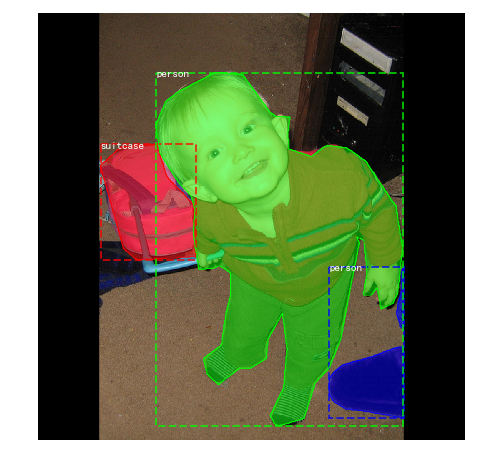

In [12]:
# 随机选出图片进行测试
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

det_instances_savepath = '07.det_instances.jpg'
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8),
                           save_path=det_instances_savepath)

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


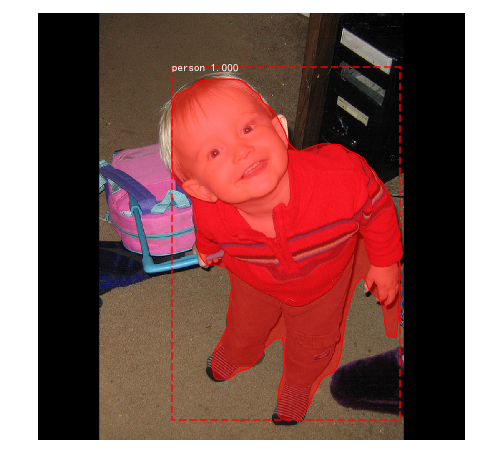

In [13]:
# 定义助手函数用于设置matplot中的子绘制区域所在的行和列
def get_ax(rows=1, cols=1, size=8):
    
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

results = inference_model.detect([original_image], verbose=1)

r = results[0]
prediction_savepath = '07.prediction.jpg'
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax(),
                            save_path=prediction_savepath)

# 评估模型

这一步我们对自己训练出的模型进行一个简单的评估。计算模型的平均精度mAP（mean Average Precision)

In [14]:
# 计算VOC类型的 mAP，条件是 IoU=0.5
# 下面的示例中只选出10张图片进行评估，增加图片数量可以增加模型评估的准确性
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = inference_model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.5753691000331725
